In [2]:
pip install torch

   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   - -------------------------------------- 5.2/110.9 MB 26.4 MB/s eta 0:00:04
   --- ------------------------------------ 10.7/110.9 MB 26.3 MB/s eta 0:00:04
   ----- ---------------------------------- 16.0/110.9 MB 26.2 MB/s eta 0:00:04
   ------- -------------------------------- 21.2/110.9 MB 26.2 MB/s eta 0:00:04
   --------- ------------------------------ 25.2/110.9 MB 24.9 MB/s eta 0:00:04
   ---------- ----------------------------- 30.1/110.9 MB 24.8 MB/s eta 0:00:04
   ------------ --------------------------- 34.6/110.9 MB 24.6 MB/s eta 0:00:04
   -------------- ------------------------- 39.8/110.9 MB 24.4 MB/s eta 0:00:03
   ---------------- ----------------------- 45.1/110.9 MB 24.5 MB/s eta 0:00:03
   ------------------ --------------------- 50.1/110.9 MB 24.6 MB/s eta 0:00:03
   ------------------- -------------------- 55.3/110.9 MB 24.7 MB/s eta 0:00:03
   --------------------- ------------------ 60.6/1

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [4]:
df = pd.read_csv('flight-price-prediction/flight_price_processed.csv')
df.head()

,Stops,Class,Duration,Days Left,Price,Airline_Air_India,Airline_GO_FIRST,Airline_Indigo,Airline_SpiceJet,Airline_Vistara,...,Departure Time_Early_Morning,Departure Time_Evening,Departure Time_Late_Night,Departure Time_Morning,Departure Time_Night,Arrival Time_Early_Morning,Arrival Time_Evening,Arrival Time_Late_Night,Arrival Time_Morning,Arrival Time_Night
0,0,0,-1.397994,-1.843875,5953,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,-1.374820,-1.843875,5953,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,-1.397994,-1.843875,5956,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,-1.386407,-1.843875,5955,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,0,-1.374820,-1.843875,5955,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [5]:
# Separate features and target variable
X = df.drop('Price', axis=1).values # Convert to NumPy array
y = df['Price'].values

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Convert to PyTorch tensors
# PyTorch works with its own tensor format, so we need to convert our data.
# PyTorch works with "Tensors" (like numpy arrays but optimized for gradients/GPUs).

# Training data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # Reshape to (N, 1)

# Testing data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [10]:
# Create DataLoaders
# This handles batching (processing 64 rows at a time instead of all 300k)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [12]:
# Define the Neural Network Architecture
class FlightPriceModel(nn.Module):
    def __init__(self, input_dim):
        super(FlightPriceModel, self).__init__()
        # Layer 1
        self.layer1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        # Layer 2
        self.layer2 = nn.Linear(64, 32)
        # Layer 3
        self.layer3 = nn.Linear(32, 16)
        # Output Layer (1 unit for Price)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.output(x) # Linear activation (no function) for regression
        return x
    
# Initialize Model
model = FlightPriceModel(input_dim=X_train.shape[1])

In [13]:
# Define Loss and Optimizer
criterion = nn.MSELoss() # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# The Training Loop (Manual in PyTorch)
epochs = 50
train_losses = []
val_losses = []

print("Starting PyTorch Training...")

for epoch in range(epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # A. Forward Pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # B. Backward Pass & Optimization
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update weights
        
        running_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation step (Evaluate on test set)
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Don't calculate gradients here (saves memory)
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.0f}, Val Loss: {val_loss.item():.0f}')

Starting PyTorch Training...
Epoch [5/50], Train Loss: 28870530, Val Loss: 29646668
Epoch [10/50], Train Loss: 24491679, Val Loss: 24398208
Epoch [15/50], Train Loss: 20847049, Val Loss: 21240028
Epoch [20/50], Train Loss: 19660281, Val Loss: 20034282
Epoch [25/50], Train Loss: 18796972, Val Loss: 19219250
Epoch [30/50], Train Loss: 18193225, Val Loss: 18715326
Epoch [35/50], Train Loss: 17696628, Val Loss: 18316288
Epoch [40/50], Train Loss: 17349822, Val Loss: 17929504
Epoch [45/50], Train Loss: 17071010, Val Loss: 17687658
Epoch [50/50], Train Loss: 16808196, Val Loss: 17212678


In [15]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy() # Convert back to numpy for sklearn

r2 = r2_score(y_test, y_pred)
print(f"\nFinal R-squared Score: {r2:.4f}")


Final R-squared Score: 0.9666


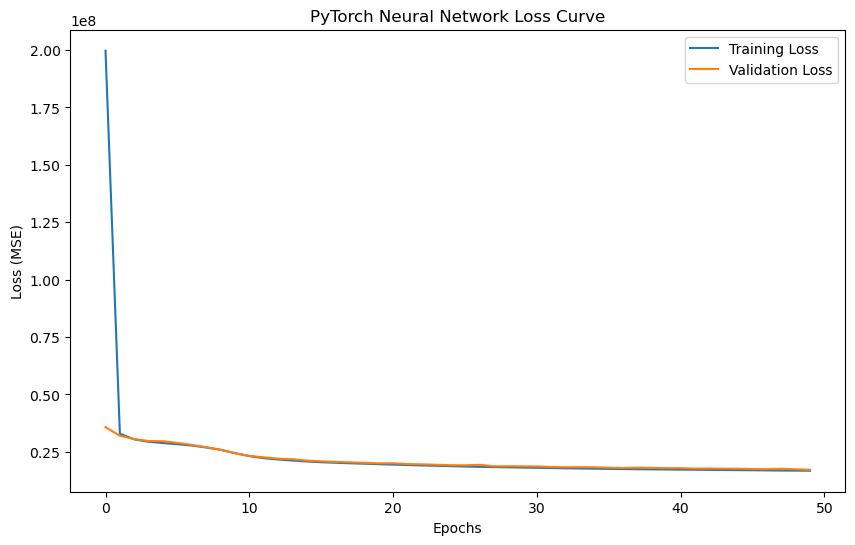

In [19]:
# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('PyTorch Neural Network Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

Key Differences from Keras
- DataLoader: In Keras, you just pass X_train and y_train. In PyTorch, you explicitly create a DataLoader to handle batching and shuffling.

- The Class Structure (nn.Module): You define the layers in __init__ and the flow of data in forward. This gives you immense control—you could add if/else statements inside forward to make the network behave differently for different data!

- The Manual Loop: You have to manually tell the optimizer to zero_grad() (reset), calculate backward() (gradients), and step() (update). This makes debugging easier because you can print variables at any step of the process.

In [18]:
# Save weights
torch.save(model.state_dict(), 'models/flight_price_model.pth')

# How to Load later
loaded_model = FlightPriceModel(input_dim=29) # Re-initialize the architecture
loaded_model.load_state_dict(torch.load('models/flight_price_model.pth'))
loaded_model.eval() # Set to evaluation mode

FlightPriceModel(
  (layer1): Linear(in_features=29, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)